In [1]:
# Importing required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('fish.csv')
df.shape

(85, 7)

In [4]:
# View top 5 rows
df.head()

,species,weight,length1,length2,length3,height,width
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1


In [5]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   species  85 non-null     object 
 1   weight   85 non-null     float64
 2   length1  85 non-null     float64
 3   length2  85 non-null     float64
 4   length3  85 non-null     float64
 5   height   85 non-null     float64
 6   width    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.8+ KB


In [6]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False)

species    0
weight     0
length1    0
length2    0
length3    0
height     0
width      0
dtype: int64

In [7]:
# Check 'species' column
df.species.value_counts()

Bream    34
Roach    20
Pike     17
Smelt    14
Name: species, dtype: int64

In [8]:
# Extract the fish species from the dataframe
species = list(df['species'])

In [9]:
# Drop 'species' columns for now
df.drop(columns=['species'], axis=1, inplace=True)
df.head()

,weight,length1,length2,length3,height,width
0,242.0,23.2,25.4,30.0,38.4,13.4
1,290.0,24.0,26.3,31.2,40.0,13.8
2,340.0,23.9,26.5,31.1,39.8,15.1
3,363.0,26.3,29.0,33.5,38.0,13.3
4,430.0,26.5,29.0,34.0,36.6,15.1


## Check Data Fitment for Clustering

In [10]:
# Importing packages
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [11]:
# Function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    d = X.shape[1] # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [12]:
# Calulate hopkins statistics
hopkins_statistic(df)

0.7114594901967651

In [13]:
# Calulate hopkins statistics average for 100 iteration
hopkins_stat = []
for i in range(100):
    hopkins_stat.append(hopkins_statistic(df))
print(sum(hopkins_stat)/len(hopkins_stat))

0.8423283793238606


This score is pretty good, general rule of thumb, score near to 1 is good for clustering.

## Optimal Number of Clusters

In [14]:
# Extract measurements
samples = df.values

In [15]:
# Build K-Means model
from sklearn.cluster import KMeans

ks = range(2, 8)
wcss = [] # within cluster sum of squares
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans.fit(samples)
    # Append the inertia to the list of inertias i.e. wcss
    wcss.append(kmeans.inertia_)
    
# Print within cluster sum of squares
print(wcss)

[4419871.500870926, 1923693.8383257918, 907281.5585757574, 525824.7125367647, 334246.9426652555, 224408.35749999998]


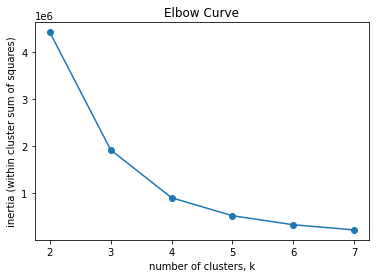

In [16]:
# Plot ks vs inertias (wcss)
plt.plot(ks, wcss, '-o')
plt.title("Elbow Curve")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia (within cluster sum of squares)')
plt.xticks(ks)
plt.show()

As we have 4 fish species, we will select 4 clusters for final model.

## Final Model

In [17]:
# Import requires packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [18]:
# Create pipeline
scaler = StandardScaler()
kmeans = KMeans(n_clusters=4)
pipeline = make_pipeline(scaler, kmeans)

In [19]:
# Get prediction
pipeline.fit(samples)
labels = pipeline.predict(samples)

## Evaluate Model

In [20]:
# Create fish dataframe
fish_df = pd.DataFrame({'labels': labels, 'species': species})
fish_df.head()

,labels,species
0,0,Bream
1,2,Bream
2,2,Bream
3,2,Bream
4,2,Bream


In [21]:
# Create cross-tabulation
ct = pd.crosstab(fish_df['labels'], fish_df['species'])
ct

species,Bream,Pike,Roach,Smelt
labels,,,,
0,1,0,19,1
1,0,17,0,0
2,33,0,1,0
3,0,0,0,13


As we can see from cross-tabulation, our final model did pretty good job here.